In [6]:
import sys
sys.path.insert(0, "/pscratch/sd/r/ritesh11/temp/mats-summer-app/src")

In [10]:
import os
from torch.utils.data import Dataset
from torch.utils.data.dataloader import DataLoader
import torch.nn.functional as F

from transformers import AutoTokenizer
import torch
from tqdm.auto import tqdm

import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

from probes.probes import TrainerConfig, LinearProbeClassification, LinearProbeClassificationMixScaler
from probes.train_test_utils import train, test 
import torch.nn as nn
from crosscoder_learning.dictionary_learning.cache import ActivationCache

import pickle
import random
import time
from tqdm import trange
tic, toc = (time.time, time.time)

In [8]:
MODEL = 'llama'

prompt_cat = "refusal"

if MODEL == 'llama':
    model_path = "../Llama-3.2-3B-Instruct/"    
    layer = 11
    MODEL_DIM = 3072
else:
    model_path = "../Llama-3.1-8B-Instruct/"
    layer = 12
    MODEL_DIM = 4096

In [9]:
tokenizer = AutoTokenizer.from_pretrained(model_path)

In [10]:
ckpt_dir = f"probe_checkpoints/controlling_probe/{prompt_cat}/{MODEL}/PRE_ASSISTANT"
ckpt_path = os.path.join(ckpt_dir,
    f"trust_probe_at_layer_{layer}_final.pth",
    )
probe = torch.load(ckpt_path)

In [13]:
diff_0 = probe['proj.0.weight'][0].cpu()
diff_1 = probe['proj.0.weight'][1].cpu()
trust_vector = diff_1 - diff_0 

In [14]:
positive_test_cache_dir = f"/pscratch/sd/r/ritesh11/temp/mats-summer-app/model_activations/{MODEL}/high_trust_dataset_{prompt_cat}/test"
negative_test_cache_dir = f"/pscratch/sd/r/ritesh11/temp/mats-summer-app/model_activations/{MODEL}/low_trust_dataset_{prompt_cat}/test"

positive_test_cache = ActivationCache(positive_test_cache_dir, f"layer_{layer}_out")
negative_test_cache = ActivationCache(negative_test_cache_dir, f"layer_{layer}_out")

pos_tokens = positive_test_cache.sequence_ranges[-1]
neg_tokens = negative_test_cache.sequence_ranges[-1]

pos_act_sim = torch.empty(pos_tokens)
neg_act_sim = torch.empty(neg_tokens)

# ensure trust_vector is normalized if you want scale-invariant probe strength
trust_vector = trust_vector / trust_vector.norm()

for i in trange(pos_tokens, desc="Positive cache scoring"):
    act = positive_test_cache[int(i)]          # [d]
    pos_act_sim[i] = torch.dot(act.float(), trust_vector)

for i in trange(neg_tokens, desc="Negative cache scoring"):
    act = negative_test_cache[int(i)]          # [d]
    neg_act_sim[i] = torch.dot(act.float(), trust_vector)

Negative cache scoring: 100%|██████████| 177633/177633 [00:08<00:00, 22011.76it/s]


In [36]:
SYSTEM_PROMPT_LEN = 26
reference = tokenizer.decode(positive_test_cache.tokens[:SYSTEM_PROMPT_LEN])
for idx in tqdm(positive_test_cache.sequence_ranges[:-1]):
    assert tokenizer.decode(positive_test_cache.tokens[idx:idx+SYSTEM_PROMPT_LEN]) == reference

  0%|          | 0/240 [00:00<?, ?it/s]

In [37]:
def plot_activation_histograms(
    pos_act_sim: torch.Tensor,
    neg_act_sim: torch.Tensor,
    pos_sequence_ranges: list,
    neg_sequence_ranges: list,
    system_prompt_len: int,
    bins: int = 200,
    max_points: int = 2_000_000,
):
    """
    Plot histograms of probe activations excluding system prompt tokens.
    """

    def strip_system_prompt(act_sim, seq_ranges):
        kept = []
        for i in range(len(seq_ranges) - 1):
            start = seq_ranges[i] + system_prompt_len
            end = seq_ranges[i + 1]
            if start < end:
                kept.append(act_sim[start:end])
        return torch.cat(kept)

    pos_clean = strip_system_prompt(pos_act_sim, pos_sequence_ranges)
    neg_clean = strip_system_prompt(neg_act_sim, neg_sequence_ranges)

    def maybe_subsample(x):
        if x.numel() > max_points:
            idx = torch.randperm(x.numel())[:max_points]
            return x[idx]
        return x

    pos = maybe_subsample(pos_clean).cpu()
    neg = maybe_subsample(neg_clean).cpu()

    lo = min(pos.min().item(), neg.min().item())
    hi = max(pos.max().item(), neg.max().item())

    plt.figure(figsize=(8, 5))
    plt.hist(
        pos.numpy(),
        bins=bins,
        range=(lo, hi),
        alpha=0.6,
        density=True,
        label="Positive",
    )
    plt.hist(
        neg.numpy(),
        bins=bins,
        range=(lo, hi),
        alpha=0.6,
        density=True,
        label="Negative",
    )

    plt.axvline(0, color="black", linestyle="--", linewidth=1)
    plt.xlabel("Probe activation (Δw · x)")
    plt.ylabel("Density")
    plt.title("Probe activation distribution (system prompt excluded)")
    plt.legend()
    plt.tight_layout()
    plt.show()


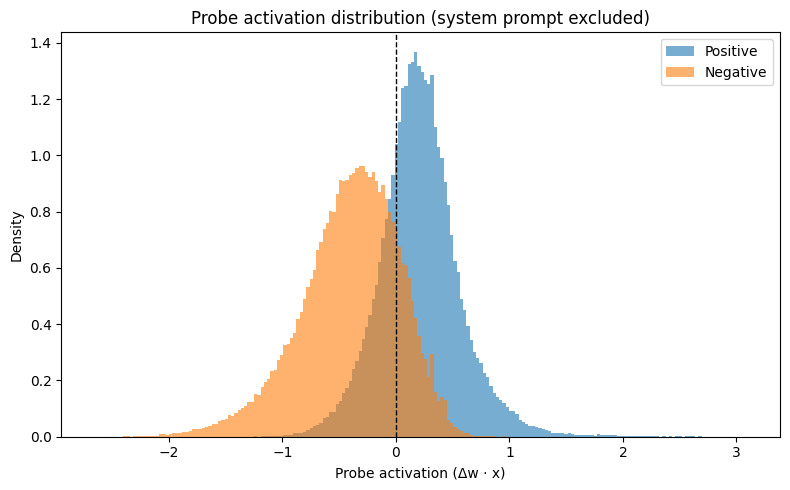

In [38]:
plot_activation_histograms(
    pos_act_sim=pos_act_sim,
    neg_act_sim=neg_act_sim,
    pos_sequence_ranges=positive_test_cache.sequence_ranges,
    neg_sequence_ranges=negative_test_cache.sequence_ranges,
    system_prompt_len=SYSTEM_PROMPT_LEN,
)

In [39]:
def top_k_unique_tokens(
    act_sim: torch.Tensor,
    tokens: torch.Tensor,
    tokenizer,
    sequence_ranges: list,
    system_prompt_len: int,
    k: int = 20,
):
    """
    Get top-k UNIQUE decoded tokens by probe activation.

    Uniqueness is enforced by decoded token string, keeping the
    maximum activation occurrence.

    Returns:
        List of (score, token_str)
    """

    special_ids = set(tokenizer.all_special_ids)

    best_by_token = {}  # token_str -> max_score

    # ---- build system-prompt mask ----
    is_system = torch.zeros_like(act_sim, dtype=torch.bool)
    for i in range(len(sequence_ranges) - 1):
        start = sequence_ranges[i]
        is_system[start : start + system_prompt_len] = True

    for idx in range(len(act_sim)):
        if is_system[idx]:
            continue

        tok_id = tokens[idx].item()

        # skip special tokens
        if tok_id in special_ids:
            continue

        tok_str = tokenizer.decode([tok_id])

        # skip whitespace / newline tokens
        if tok_str.strip() == "":
            continue
        if all(ch == "\n" for ch in tok_str):
            continue

        score = act_sim[idx].item()

        # keep max activation per unique token string
        if tok_str not in best_by_token or score > best_by_token[tok_str]:
            best_by_token[tok_str] = score

    # ---- sort by score ----
    sorted_tokens = sorted(
        best_by_token.items(),
        key=lambda x: x[1],
        reverse=True,
    )

    # return top-k
    return sorted_tokens[-k:]

In [40]:
ref_val = pos_act_sim.quantile(0.95).item()

In [41]:
ref_val

0.8045418858528137

In [42]:
positive_test_cache_dir = f"/pscratch/sd/r/ritesh11/temp/mats-summer-app/model_activations/{MODEL}/user_description/trustworthy"
negative_test_cache_dir = f"/pscratch/sd/r/ritesh11/temp/mats-summer-app/model_activations/{MODEL}/user_description/untrustworthy"

positive_test_cache = ActivationCache(positive_test_cache_dir, f"layer_{layer}_out")
negative_test_cache = ActivationCache(negative_test_cache_dir, f"layer_{layer}_out")

pos_tokens = positive_test_cache.sequence_ranges[-1]
neg_tokens = negative_test_cache.sequence_ranges[-1]

pos_act_sim = torch.empty(pos_tokens)
neg_act_sim = torch.empty(neg_tokens)

# ensure trust_vector is normalized if you want scale-invariant probe strength
trust_vector = trust_vector / trust_vector.norm()

for i in trange(pos_tokens, desc="Positive cache scoring"):
    act = positive_test_cache[int(i)]          # [d]
    pos_act_sim[i] = torch.dot(act.float(), trust_vector)

for i in trange(neg_tokens, desc="Negative cache scoring"):
    act = negative_test_cache[int(i)]          # [d]
    neg_act_sim[i] = torch.dot(act.float(), trust_vector)

Negative cache scoring: 100%|██████████| 3833/3833 [00:00<00:00, 12831.81it/s]


In [43]:
SYSTEM_PROMPT_LEN = 26
reference = tokenizer.decode(positive_test_cache.tokens[:SYSTEM_PROMPT_LEN])
for idx in tqdm(positive_test_cache.sequence_ranges[:-1]):
    assert tokenizer.decode(positive_test_cache.tokens[idx:idx+SYSTEM_PROMPT_LEN]) == reference

  0%|          | 0/30 [00:00<?, ?it/s]

In [44]:
def top_k_sequences_with_scores(
    act_sim: torch.Tensor,
    sequence_ranges: list,
    k: int,
    aggregation: str = "max",
    tail: str = "top",
):
    assert aggregation in {"mean", "max"}
    assert tail in {"top", "bottom"}

    scored = []

    for i in range(len(sequence_ranges) - 1):
        start = sequence_ranges[i]
        end = sequence_ranges[i + 1]

        seq_scores = act_sim[start:end]
        if seq_scores.numel() == 0:
            continue

        agg_score = (
            seq_scores.mean() if aggregation == "mean" else seq_scores.max()
        )

        scored.append((agg_score.item(), start, end))

    scored.sort(key=lambda x: x[0], reverse=(tail == "top"))
    return scored[:k]   # (score, start, end)

In [45]:
def get_sorted_sequences_by_mean(
    act_sim: torch.Tensor,
    sequence_ranges: list,
    system_prompt_len: int = 28,
):
    scored = []

    for i in range(len(sequence_ranges) - 1):
        start = sequence_ranges[i] + system_prompt_len
        end = sequence_ranges[i + 1]

        if start >= end:
            continue

        mean_score = act_sim[start:end].mean().item()
        scored.append((mean_score, start, end))

    scored.sort(key=lambda x: x[0], reverse=True)
    return scored  # [(mean_score, start, end), ...]


In [46]:
import html
import numpy as np
from IPython.display import HTML, display

def visualize_probe_token_heatmap(
    tokenizer,
    toks,
    activations,
    ref_val
):
    """
    HTML heatmap for probe activations over tokens.

    Args:
        tokenizer: HuggingFace tokenizer
        toks: token ids [seq_len]
        activations: tensor [seq_len] (dot or cosine scores)
    """

    # --- ensure 1D ---
    if toks.ndim == 2:
        toks = toks[0]

    acts = activations.detach().cpu().numpy()

    # --- normalize by reference magnitude ---
    max_val = ref_val
    if max_val > 0:
        acts = acts / max_val
    else:
        acts = acts * 0.0

    # --- decode once ---
    decoded_text = tokenizer.decode(
        toks, clean_up_tokenization_spaces=False
    )

    # --- re-tokenize for offsets ---
    encoding = tokenizer(
        decoded_text,
        return_offsets_mapping=True,
        add_special_tokens=False,
    )

    offsets = encoding["offset_mapping"]

    html_output = ""
    last_end = 0

    for i, (start, end) in enumerate(offsets):
        html_output += html.escape(decoded_text[last_end:start])

        token_text = decoded_text[start:end]
        escaped_token = html.escape(token_text)

        if i < len(acts) and abs(acts[i]) > 1e-6:
            if acts[i] > 0:
                color = f"rgba(255, 0, 0, {abs(acts[i]):.2f})"   # red
            else:
                color = f"rgba(0, 0, 255, {abs(acts[i]):.2f})"  # blue

            html_output += (
                f'<span style="background-color: {color}" '
                f'title="Probe activation: {acts[i]:.3f}">'
                f'{escaped_token}</span>'
            )
        else:
            html_output += escaped_token

        last_end = end

    html_output += html.escape(decoded_text[last_end:])

    display(
        HTML(
            "<div style='font-family: monospace; white-space: pre-wrap;'>"
            + html_output +
            "</div>"
        )
    )


In [47]:
def visualize_sequence_by_rank(
    idx: int,
    sorted_seqs: list,
    cache,
    act_sim: torch.Tensor,
    tokenizer,
):
    """
    Visualize token-level probe heatmap for a ranked sequence.

    Args:
        idx: index into sorted_seqs (0 = top, -1 = bottom, etc.)
        sorted_seqs: list of (mean_score, start, end)
        cache: activation cache with `.tokens`
        act_sim: per-token probe activations [num_tokens]
        tokenizer: HF tokenizer
    """
    mean_score, start, end = sorted_seqs[idx]

    print(f"Mean probe activation: {mean_score:.4f}")

    toks = cache.tokens[start:end]
    acts = act_sim[start:end]

    visualize_probe_token_heatmap(
        tokenizer=tokenizer,
        toks=toks,
        activations=acts,
        ref_val=ref_val
    )

In [48]:
sorted_seqs = get_sorted_sequences_by_mean(
    act_sim=pos_act_sim,
    sequence_ranges=positive_test_cache.sequence_ranges,
    system_prompt_len=SYSTEM_PROMPT_LEN,
)

In [53]:
# visualize top sequence
visualize_sequence_by_rank(
    idx=29,
    sorted_seqs=sorted_seqs,
    cache=positive_test_cache,
    act_sim=pos_act_sim,
    tokenizer=tokenizer,
)

Mean probe activation: -0.0976


In [54]:
sorted_seqs = get_sorted_sequences_by_mean(
    act_sim=neg_act_sim,
    sequence_ranges=negative_test_cache.sequence_ranges,
    system_prompt_len=SYSTEM_PROMPT_LEN,
)

In [56]:
# visualize top sequence
visualize_sequence_by_rank(
    idx=29,
    sorted_seqs=sorted_seqs,
    cache=negative_test_cache,
    act_sim=neg_act_sim,
    tokenizer=tokenizer,
)

Mean probe activation: -0.1536


# CALCULATE TEST ACCURACY

In [11]:
from enum import IntEnum

class ACT_TOKEN(IntEnum):
    PRE_ASSISTANT = 1 # Just before model's first generation
    EOS = 5
    PRE_EOS = 6
    
act_token = ACT_TOKEN.PRE_ASSISTANT
avg_act = False
NUM_CLASSES = 2
prompt_cat = "refusal"

MODEL = 'llama'

if MODEL == 'llama':
    model_path = "../../Llama-3.2-3B-Instruct/"
    layers = [i for i in range(5,20,2)]
    MODEL_DIM = 3072
else:
    model_path = "../../Llama-3.1-8B-Instruct/"
    layers = [i for i in range(11,20,2)]
    MODEL_DIM = 4096

layer_map = {l:i for l,i in zip(layers, [j for j in range(len(layers))]) }

In [12]:
print(MODEL)
print(prompt_cat)

llama
refusal


In [13]:
tokenizer = AutoTokenizer.from_pretrained(model_path)

In [38]:
positive_test_cache_dir = f"/pscratch/sd/r/ritesh11/temp/mats-summer-app/model_activations/{MODEL}/user_description/trustworthy"
negative_test_cache_dir = f"/pscratch/sd/r/ritesh11/temp/mats-summer-app/model_activations/{MODEL}/user_description/untrustworthy"

In [39]:
def get_acts(
    test_dir: str,
    layer_num: int,
    act_token: ACT_TOKEN,
    return_mean: bool,
):
    test_cache = ActivationCache(test_dir, f"layer_{layer_num}_out")

    offset = 5

    # end indices (one per example)
    end_idxs = test_cache.sequence_ranges[1:] - offset
    start_idxs = test_cache.sequence_ranges[:-1]

    if return_mean:
        # mean over token span for each example
        test_acts = torch.stack(
            [
                torch.mean(
                    torch.stack(
                        [test_cache[int(i)] for i in range(start, end)],
                        dim=0,
                    ),
                    dim=0,
                )
                for start, end in zip(start_idxs, end_idxs)
            ],
            dim=0,
        )
    else:
        # single-token activation (e.g. last token minus offset)
        test_acts = torch.stack(
            [test_cache[int(idx)] for idx in end_idxs],
            dim=0,
        )

    return test_acts

In [40]:
test_cache  = None
test_labels  = None

for i, layer in tqdm(enumerate(layers), total=len(layers)):

    # -------- positive --------
    pte = get_acts(
        positive_test_cache_dir,
        layer,
        act_token,
        avg_act
    )

    # -------- negative --------
    nte = get_acts(
        negative_test_cache_dir,
        layer,
        act_token,
        avg_act
    )

    # cast ONCE (important)
    pte = pte.float()
    nte = nte.float()

    # -------- lazy init (first layer only) --------
    if test_cache is None:
        
        test_cache = torch.empty(
            pte.shape[0] + nte.shape[0],
            len(layers),
            pte.shape[1],
            device=pte.device,
            dtype=torch.float32,   # 🔑 enforce float32
        )

        test_labels = torch.cat([
            torch.ones(pte.shape[0], dtype=torch.long, device=pte.device),
            torch.zeros(nte.shape[0], dtype=torch.long, device=pte.device),
        ])

        pos_test_end  = pte.shape[0]

    # -------- fill caches --------
    test_cache[:pos_test_end, i, :] = pte
    test_cache[pos_test_end:, i, :] = nte

  0%|          | 0/8 [00:00<?, ?it/s]

In [41]:
class ActivationDataset(Dataset):
    def __init__(self, cache: torch.Tensor, labels: torch.Tensor):
        """
        Args:
            cache: Tensor of shape (N, L, D)
            labels: Tensor of shape (N,)
        """
        assert cache.shape[0] == labels.shape[0], \
            "Cache and labels must have same number of samples"

        self.cache = cache
        self.labels = labels

    def __len__(self):
        return self.cache.shape[0]

    def __getitem__(self, idx):
        return {
            "activation": self.cache[idx],
            "label": self.labels[idx],
        }

In [42]:
test_dataset  = ActivationDataset(test_cache, test_labels)
test_loader = DataLoader(test_dataset, shuffle=False, pin_memory=True, batch_size=400, num_workers=1)

In [43]:
loss_func = nn.BCELoss()
torch_device = "cuda"

In [44]:
ckpt_dir = f"../outputs/probe_checkpoints/controlling_probe/{prompt_cat}/{MODEL}/PRE_ASSISTANT"

In [45]:
from sklearn.metrics import (
    confusion_matrix,
    ConfusionMatrixDisplay,
    precision_recall_fscore_support,
)

import pandas as pd

---------------------------------------- Layer 5 -> 0 ----------------------------------------
Test set: Average loss: 0.6931,  Accuracy: 0.500

Test accuracy: 0.5000


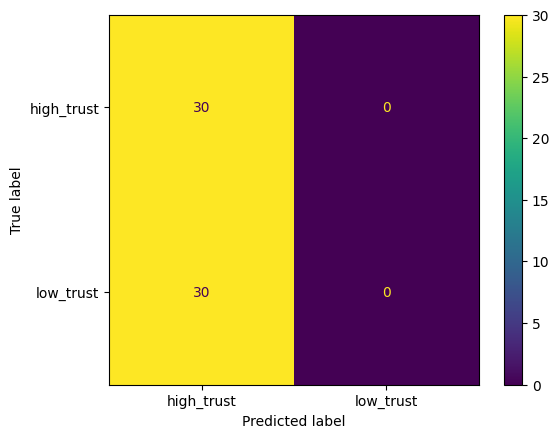

---------------------------------------- Layer 7 -> 1 ----------------------------------------
Test set: Average loss: 0.6514,  Accuracy: 0.617

Test accuracy: 0.6167


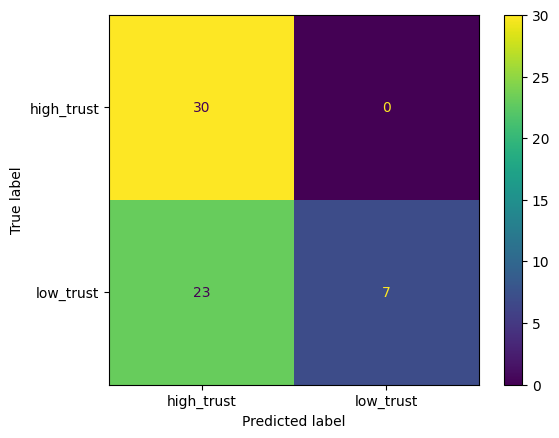

---------------------------------------- Layer 9 -> 2 ----------------------------------------
Test set: Average loss: 0.6659,  Accuracy: 0.567

Test accuracy: 0.5667


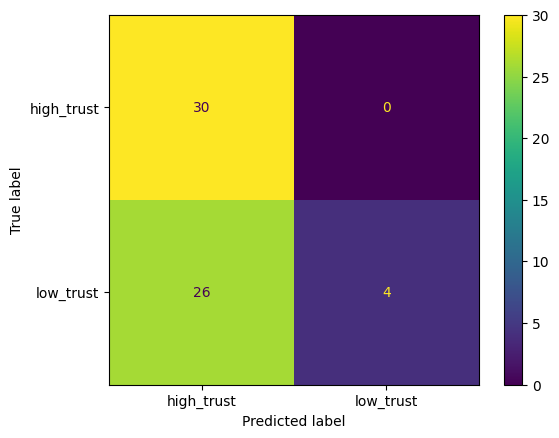

---------------------------------------- Layer 11 -> 3 ----------------------------------------
Test set: Average loss: 0.6209,  Accuracy: 0.850

Test accuracy: 0.8500


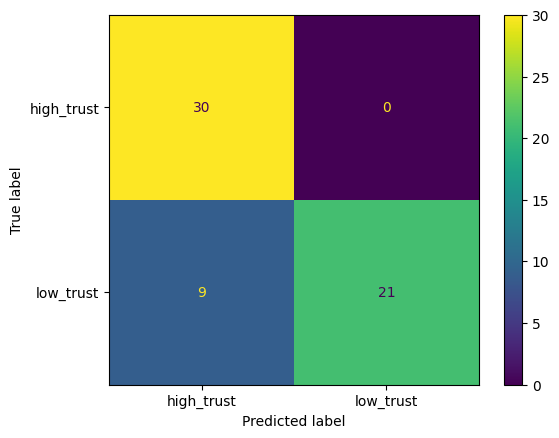

---------------------------------------- Layer 13 -> 4 ----------------------------------------
Test set: Average loss: 0.5989,  Accuracy: 0.700

Test accuracy: 0.7000


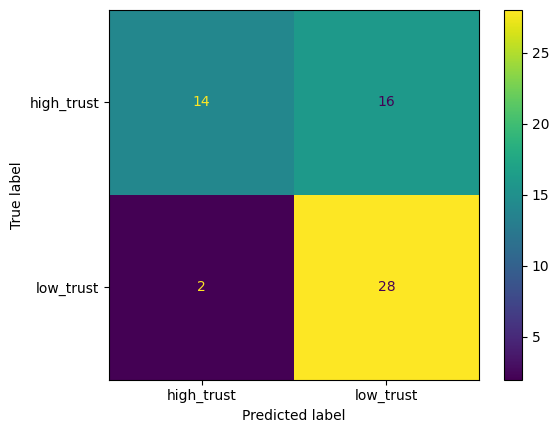

---------------------------------------- Layer 15 -> 5 ----------------------------------------
Test set: Average loss: 0.6048,  Accuracy: 0.850

Test accuracy: 0.8500


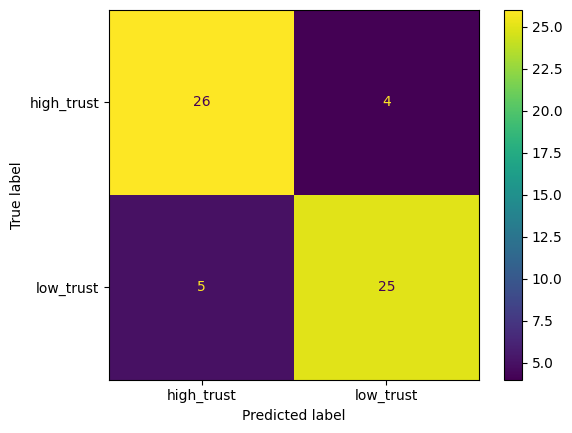

---------------------------------------- Layer 17 -> 6 ----------------------------------------
Test set: Average loss: 0.6135,  Accuracy: 0.833

Test accuracy: 0.8333


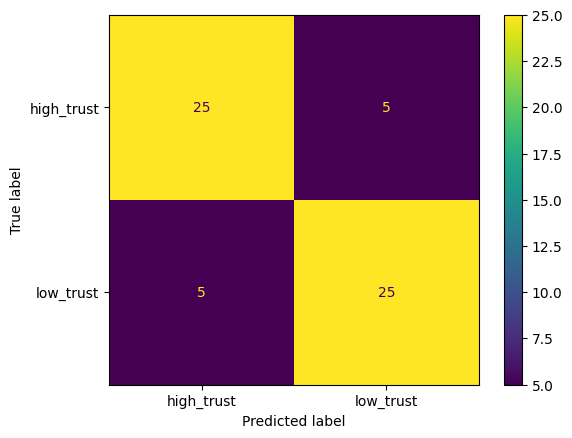

---------------------------------------- Layer 19 -> 7 ----------------------------------------
Test set: Average loss: 0.6082,  Accuracy: 0.650

Test accuracy: 0.6500


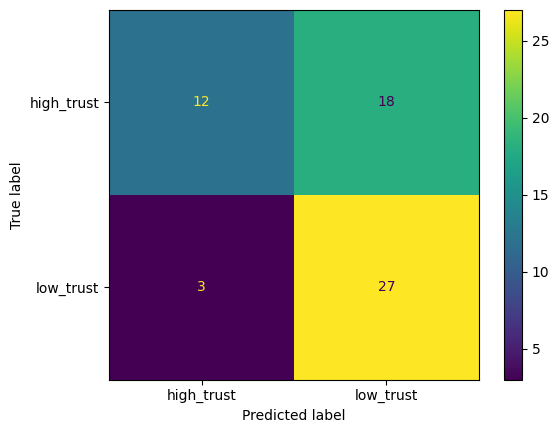


FINAL PROBE PERFORMANCE SUMMARY
 layer  layer_num  accuracy  precision  recall     f1
     5          0    0.5000     0.0000  0.0000 0.0000
     7          1    0.6167     1.0000  0.2333 0.3784
     9          2    0.5667     1.0000  0.1333 0.2353
    11          3    0.8500     1.0000  0.7000 0.8235
    13          4    0.7000     0.6364  0.9333 0.7568
    15          5    0.8500     0.8621  0.8333 0.8475
    17          6    0.8333     0.8333  0.8333 0.8333
    19          7    0.6500     0.6000  0.9000 0.7200


In [46]:
# ---------------------------------------------------------
# Accumulator for final metrics
# ---------------------------------------------------------
rows = []

# ---------------------------------------------------------
# Main evaluation loop
# ---------------------------------------------------------
for layer in layers:
    layer_num = layer_map[layer]

    print("-" * 40 + f" Layer {layer} -> {layer_num} " + "-" * 40)

    # ---- load probe ----
    probe = LinearProbeClassification(
        probe_class=NUM_CLASSES,
        device="cuda",
        input_dim=MODEL_DIM,
        logistic=True,
    )

    ckpt_path = os.path.join(
        ckpt_dir,
        f"trust_probe_at_layer_{layer}_final.pth",
    )

    probe.load_state_dict(torch.load(ckpt_path, map_location="cuda"))
    probe.eval()

    # ---- inference ----
    with torch.no_grad():
        test_results = test(
            probe,
            torch_device,
            test_loader,
            loss_func=loss_func,
            return_raw_outputs=True,
            verbose=True,
            layer_num=layer_num,
            one_hot=True,
            num_classes=NUM_CLASSES,
        )

    # ---- unpack results ----
    acc = test_results[1]
    y_pred = test_results[2]
    y_true = test_results[3]

    print(f"Test accuracy: {acc:.4f}")

    # ---- confusion matrix ----
    cm = confusion_matrix(y_true, y_pred)
    ConfusionMatrixDisplay(
        cm,
        display_labels=["high_trust", "low_trust"],
    ).plot()
    plt.show()

    # ---- precision / recall / f1 ----
    precision, recall, f1, _ = precision_recall_fscore_support(
        y_true,
        y_pred,
        average="binary",
        pos_label=1,      # change to 0 if labels are reversed
        zero_division=0,
    )

    # ---- store metrics ----
    rows.append({
        "layer": layer,
        "layer_num": layer_num,
        "accuracy": acc,
        "precision": precision,
        "recall": recall,
        "f1": f1,
    })

# ---------------------------------------------------------
# Final summary table
# ---------------------------------------------------------
df_metrics = pd.DataFrame(rows)
df_metrics = df_metrics.sort_values("layer_num").reset_index(drop=True)

print("\nFINAL PROBE PERFORMANCE SUMMARY")
print("=" * 90)
print(df_metrics.to_string(index=False, float_format="%.4f"))
print("=" * 90)